In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import scipy

%matplotlib inline

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

     fun: 2393.204768472884
    nfev: 31
     nit: 26
 success: True
       x: -1.8511718515349764


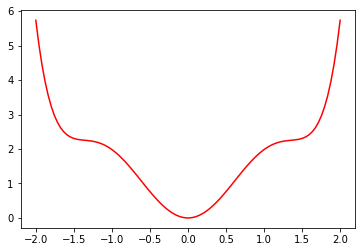

In [3]:
def six_hump(x,y):
    return (4-2.1*x**2 + x**4/3)*x**2+x*y+(4*y**2-4)*y**2

x=np.linspace(-2,2, 100)
y=np.linspace(-1,1,100)


plt.plot(x, six_hump(x, y), 'r')
from scipy.optimize import brentq
sol = optimize.minimize_scalar(six_hump, args=(5,))
print(sol)

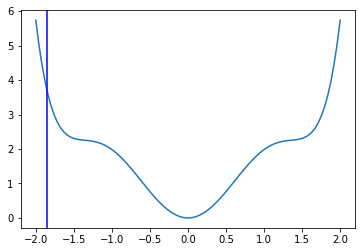

In [4]:
plt.plot(x, six_hump(x, y))
plt.axvline(sol['x'], color='b')

In [5]:
from scipy.optimize import basinhopping

x0 = -10
solution = basinhopping(six_hump, x0, stepsize=1, minimizer_kwargs={'args': (8,)}) # see how the parameters are passed to the function
print(solution)

                        fun: 16115.54630956303
 lowest_optimization_result:       fun: 16115.54630956303
 hess_inv: array([[0.02049069]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([-1.9182376])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1722
                        nit: 100
                       njev: 861
                          x: array([-1.9182376])


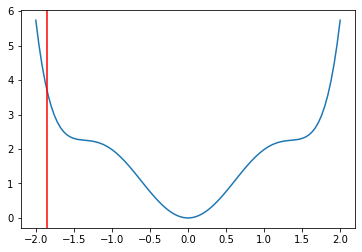

In [41]:
plt.plot(x, six_hump(x, y))
plt.axvline(solution['x'], color='r')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

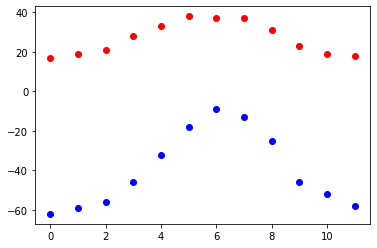

In [26]:
max_temp = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])


month = np.arange(12)

# fig, ax = plt.subplots(figsize=(10,6))
# ax.scatter(x=x, y=y, marker='o', c='r', label="data")

plt.plot(max_temp,  'ro')
plt.plot(min_temp,'bo')


In [ ]:
# curve fitting 



In [31]:
#function finding Max and min




def max_min(x_max, x_min, y_max, y_min):
    x_max = np.max(x)
    x_min = np.min(x)
    y_max = np.max(y)
    y_min = np.min(y)
    
    return x_max, x_min, y_max,  y_min
    
x = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
y = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
    
max_min(x, x, y, y)

(38, 17, -9, -62)

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.